# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Описание данных:

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

- `Price` — цена (евро)

Какие погрешности есть в данных: пропуски + несоответствие типов данных их описанию. К тому же нужно будет разобраться с данными типа object

In [5]:
df.duplicated().sum()

4

Избавляемся

In [6]:
df = df.drop_duplicates()

In [7]:
df.describe(include='int')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Из интов: нулевая цена, регистрация в 1000 и 9999 годах, 0 и 20000 л.с., нулевой месяц регистрации, ни одной фотографии и смущает почтовый индекс в целом как признак, думаю, что он особо не значит, возможно, позже удалим.

In [8]:
df.describe(include=object)

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354365,316875,334532,334660,321470,354365,283211,354365,354365
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268249,29232,216349,77012,247158,13718,17


NotRepaired точно уйдет в булеан, DateCreated скорее всего не нужен, как и LastSeen и DateCrawled. Остальные закодируем

Начнем с интов: поскольку картинок не завезли, столбец бесполезен, удаляем его. Также все-таки удалю индекс

In [9]:
df = df.drop(['NumberOfPictures', 'PostalCode'], axis=1)

In [10]:
len(df[df['Price'] == 0])

10772

Машин с нулевой ценой порядка 3%, что немало, но с такими ценами далеко не уедешь

In [11]:
df = df[df['Price'] != 0]

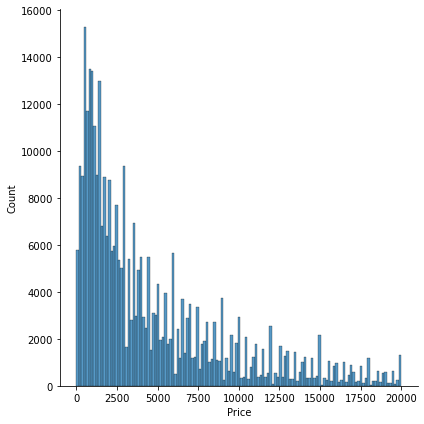

In [12]:
sns.displot(df, x='Price', height=6)

Вообще здесь ненормальное распределение, наверное нужно отлагорифмировать, но пока оставлю (не уверен просто, всегда ли нужно приводить данные к нормальному виду) (Мысль о приведении данных к нормальному распроcтраняется и к следующим данным)

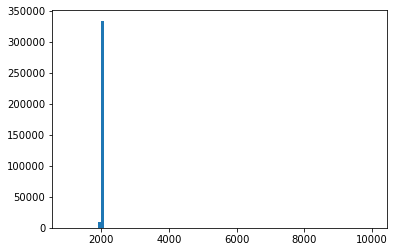

In [13]:
plt.hist(df['RegistrationYear'], bins=100);

От выбросов также страдает признак `Power`

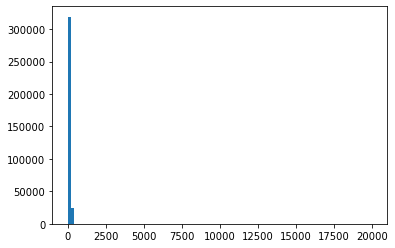

In [14]:
plt.hist(df['Power'], bins=100);

Уберем выбросы с помощью квантилей

In [15]:
for col in ['RegistrationYear', 'Power']:
    high_quantile = 0.975
    low_quantile = 0.025
    filtered_count = len(df[df[col] > df[col].quantile(high_quantile)]) + \
    len(df[df[col] < df[col].quantile(low_quantile)])
    len_data = len(df)
    # отфильртуем все, что больше 0,95 квантиля
    print(f"В колонке {col} отфильтруем {filtered_count} значений, что составляет {filtered_count / len_data:.02f}% от датасета")
    # здесь я удаляю полностью строки с выбросами, возможно, имеет смысл просто удалить значения в столбцах
    df = df[(df[col] < df[col].quantile(high_quantile)) & 
                (df[col] > df[col].quantile(low_quantile))]

В колонке RegistrationYear отфильтруем 11573 значений, что составляет 0.03% от датасета
В колонке Power отфильтруем 7999 значений, что составляет 0.02% от датасета


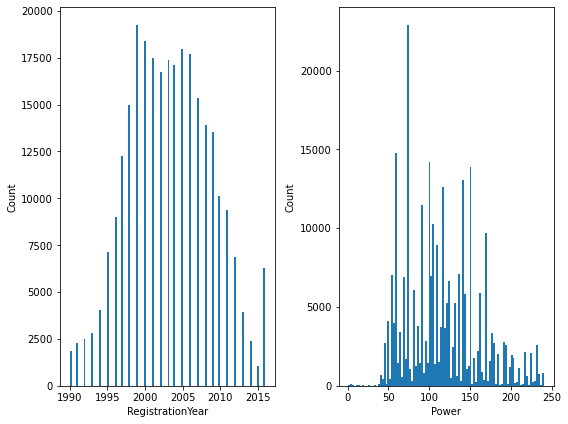

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
ax[0].hist(df['RegistrationYear'], bins=100, );
ax[0].set_xlabel('RegistrationYear')
ax[0].set_ylabel('Count')
ax[1].hist(df['Power'], bins=100);
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Count')
plt.tight_layout()

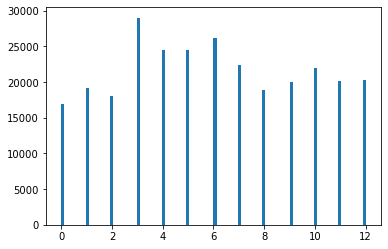

In [17]:
plt.hist(df['RegistrationMonth'], bins=100);

13 месяцев в году (если один добавили на лето, я оставляю). А так я бы спроосил у бизнеса, возможно нулевой месяц подразумевался как январь, но пока сносим 

In [18]:
df = df[df['RegistrationMonth'] != 0]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264744 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        264744 non-null  object
 1   Price              264744 non-null  int64 
 2   VehicleType        257377 non-null  object
 3   RegistrationYear   264744 non-null  int64 
 4   Gearbox            261151 non-null  object
 5   Power              264744 non-null  int64 
 6   Model              256906 non-null  object
 7   Kilometer          264744 non-null  int64 
 8   RegistrationMonth  264744 non-null  int64 
 9   FuelType           254085 non-null  object
 10  Brand              264744 non-null  object
 11  NotRepaired        232378 non-null  object
 12  DateCreated        264744 non-null  object
 13  LastSeen           264744 non-null  object
dtypes: int64(5), object(9)
memory usage: 30.3+ MB


Меня немного смущает, что я снес уже около 100000 строк, но пока оставим так

Переходим к object

Предполагаем, что даты нам особо не помогут, поэтому эти мтолбцы сносим (агрессивный EDA как-то получается)

In [20]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

Столбец NotRepaired нужно перевести в тип boolean. Там есть пропуски. Предположим, что раз записей о ремонте нет, то машина не была в ремонте (тут немного запутался, если yes, значит не была, правильно?)

In [21]:
df['NotRepaired'] = df['NotRepaired'].replace({'yes':1, 'no':0}).fillna(1).astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264744 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              264744 non-null  int64 
 1   VehicleType        257377 non-null  object
 2   RegistrationYear   264744 non-null  int64 
 3   Gearbox            261151 non-null  object
 4   Power              264744 non-null  int64 
 5   Model              256906 non-null  object
 6   Kilometer          264744 non-null  int64 
 7   RegistrationMonth  264744 non-null  int64 
 8   FuelType           254085 non-null  object
 9   Brand              264744 non-null  object
 10  NotRepaired        264744 non-null  bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 22.5+ MB


Тут загвоздка: я знаю, что с помощью CatBoost можно обрабатывать обджекты (либо он умеет строить модели и при этом сам обрабатывает их, точно не знаю). Наверняка с LightGBM можно тоже что-то такое провернуть. Самому разобраться пока не получилось, поэтому по старинке обработаю их 

In [22]:
df.isna().sum()

Price                    0
VehicleType           7367
RegistrationYear         0
Gearbox               3593
Power                    0
Model                 7838
Kilometer                0
RegistrationMonth        0
FuelType             10659
Brand                    0
NotRepaired              0
dtype: int64

Тип топлива, коробки передач и автомобиля можно заполнить медианами, а вот с моделью такого не сделать. Поскольку в столбце Brand пропусков нет, можно попробовать заменить самыми популярными моделями этого бренда.

С другой стороны, модель автомобиля должна достаточно сильно влиять на стоимость, поэтому наверное все-таки выбросим эти данные

In [23]:
df = df.dropna(subset=['Model'])

In [24]:
df.isna().sum()

Price                   0
VehicleType          6387
RegistrationYear        0
Gearbox              3286
Power                   0
Model                   0
Kilometer               0
RegistrationMonth       0
FuelType             8955
Brand                   0
NotRepaired             0
dtype: int64

In [25]:
for col in ['VehicleType', 'Gearbox', 'FuelType']:
    moda = df[col].mode()
    df[col] = df[col].fillna(str(moda))

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256906 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              256906 non-null  int64 
 1   VehicleType        256906 non-null  object
 2   RegistrationYear   256906 non-null  int64 
 3   Gearbox            256906 non-null  object
 4   Power              256906 non-null  int64 
 5   Model              256906 non-null  object
 6   Kilometer          256906 non-null  int64 
 7   RegistrationMonth  256906 non-null  int64 
 8   FuelType           256906 non-null  object
 9   Brand              256906 non-null  object
 10  NotRepaired        256906 non-null  bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 21.8+ MB


Здесь я сделаю копию датафрейма для проверки работы с CatBoost и для линейной модели

In [27]:
df_cat = df.copy()
df_ohe = df.copy()

In [28]:
encoder = OrdinalEncoder()
obj_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
df[obj_cols] = encoder.fit_transform(df[obj_cols])

df_ohe = pd.get_dummies(df_ohe, columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'], drop_first=True)

In [29]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256906 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              256906 non-null  int64  
 1   VehicleType        256906 non-null  float64
 2   RegistrationYear   256906 non-null  int64  
 3   Gearbox            256906 non-null  float64
 4   Power              256906 non-null  int64  
 5   Model              256906 non-null  float64
 6   Kilometer          256906 non-null  int64  
 7   RegistrationMonth  256906 non-null  int64  
 8   FuelType           256906 non-null  float64
 9   Brand              256906 non-null  float64
 10  NotRepaired        256906 non-null  bool   
dtypes: bool(1), float64(5), int64(5)
memory usage: 21.8 MB


## Обучение моделей

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
df.drop('Price', axis=1), df['Price'], test_size=0.33, random_state=42)

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
df_ohe.drop('Price', axis=1), df_ohe['Price'], test_size=0.33, random_state=42)

Нечнем с перебора моделей

In [32]:
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [33]:
%%time


MLA = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    KNeighborsRegressor(),
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', 'RMSE', 'Time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__
    if model == LinearRegression():
        tic = time.perf_counter()
        cv_results = cross_val_score(model, X_train_ohe, y_train_ohe, cv=5, scoring=rmse, n_jobs=-1)
        toc = time.perf_counter()
    else:    
        tic = time.perf_counter()
        cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse, n_jobs=-1)
        toc = time.perf_counter()
    MLA_compare.loc[row_index, 'RMSE'] = cv_results.mean()
    MLA_compare.loc[row_index, 'Time'] = toc - tic
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['RMSE'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 344 ms
Wall time: 49.3 s


,Model,RMSE,Time
2,RandomForestRegressor,-1515.150564,41.028995
3,LGBMRegressor,-1558.387462,1.602221
4,KNeighborsRegressor,-1888.677273,2.339463
1,DecisionTreeRegressor,-1953.793544,1.855057
0,LinearRegression,-2648.833147,2.476454


Случайный лес выдал лучший результат, но оказался самым длительным. LightGBM быстрее всех выдал второй по точности результат, с ним и продолжим развлекаться 

In [34]:
# %%time

# lgbm = LGBMRegressor()

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
# max_depth = [int(x) for x in np.linspace(5, 30, num = 10)]
# num_leaves = [int(x) for x in np.linspace(50, 200, num=20)]


# param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'num_leaves': num_leaves,
# }

# rf_random = RandomizedSearchCV(estimator = lgbm, 
#                                param_distributions = param_grid, 
#                                n_iter = 15,
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring=rmse,
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

Метрика улучшилась со следующими параметрами модели: {'num_leaves': 105, 'n_estimators': 810, 'max_depth': 27}

Ради интереса можем поперебирать параметры для остальных моделей за исключением случайного леса (в силу своей длительности) и линейной регрессии (нечего перебирать)

In [35]:
# %%time

# knr = KNeighborsRegressor()

# n_neighbours = [int(x) for x in np.linspace(start = 5, stop = 15, num = 10)]

# param_grid = {
#     'n_neighbors': n_neighbours,
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree']
# }

# rf_random = RandomizedSearchCV(estimator = knr, 
#                                param_distributions = param_grid, 
#                                n_iter = 15,
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring=rmse,
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

RMSE: 1823.3 при следующих параметрах: {'weights': 'distance', 'n_neighbors': 7, 'algorithm': 'ball_tree'}

Выдал результат хуже, что немного странно

In [36]:
%%time

tree = DecisionTreeRegressor()

max_depth = [int(x) for x in np.linspace(5, 60, num = 30)]


param_grid = {
    'max_depth': max_depth,
}

rf_random = RandomizedSearchCV(estimator = tree, 
                               param_distributions = param_grid, 
                               n_iter = 15,
                               cv = 5, 
                               verbose=2, 
                               random_state=42,
                               scoring=rmse,
                               n_jobs = -1)

rf_random.fit(X_train, y_train)
print(rf_random.best_score_)
print(rf_random.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
-1768.926087536413
{'max_depth': 12}
CPU times: total: 1.42 s
Wall time: 9.17 s


RMSE: 1767.6 при параметре {'max_depth': 12}

Остаемся на бустинге

Еще хотел попробовать CatBoost. Ходят слухи, что он может сам работать с категориальными переменными, даже если в них есть пропуски 

Спойлер: пропусков в категориальных фичах быть не может

In [37]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
df_cat.drop('Price', axis=1), df_cat['Price'], test_size=0.33, random_state=42)

In [38]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172127 entries, 128186 to 168207
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        172127 non-null  object
 1   RegistrationYear   172127 non-null  int64 
 2   Gearbox            172127 non-null  object
 3   Power              172127 non-null  int64 
 4   Model              172127 non-null  object
 5   Kilometer          172127 non-null  int64 
 6   RegistrationMonth  172127 non-null  int64 
 7   FuelType           172127 non-null  object
 8   Brand              172127 non-null  object
 9   NotRepaired        172127 non-null  bool  
dtypes: bool(1), int64(4), object(5)
memory usage: 13.3+ MB


Выделим категориальные признаки для атрибута cat_features

In [39]:
cats = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
cat_1 = CatBoostRegressor(cat_features=cats)
cat_2 = CatBoostRegressor()

In [40]:
tic = time.perf_counter()
cat_1.fit(X_train_cat, y_train_cat,verbose=False, cat_features=cats)
toc = time.perf_counter()

print(f'Время обучения CatBoost с категориальными признаками: {toc-tic}')

Время обучения CatBoost с категориальными признаками: 76.8781753


In [41]:
tic = time.perf_counter()
cat_2.fit(X_train, y_train,verbose=False)
toc = time.perf_counter()

print(f'Время обучения CatBoost с закодированными категориальными признаками: {toc-tic}')

Время обучения CatBoost с закодированными категориальными признаками: 10.471350299999983


CatBoost выдал лучший результат за 35 секунд, что многовато. Попробуеум улучшить результат перебором параметров

In [42]:
# cat = CatBoostRegressor()
# grid = {'depth'         : [4,5,6,7,8,9, 10],
#        'learning_rate' : [0.01,0.02,0.03,0.04],
#        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
#                 }

# grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

Лучший результат перебора: 1666.5. При том, что CatBoost относительно долго обучается и результат далеко не лучший, от него откажемся

Сделаем еще пару пайплайнов 

In [43]:
pipeline=ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OrdinalEncoder(),obj_cols),
])

new_X = pipeline.fit_transform(X_train_cat)
pipe1 = make_pipeline(LGBMRegressor(num_leaves=105, n_estimators=810, max_depth=27))

pipe2 = make_pipeline(DecisionTreeRegressor(max_depth=12))

print(
    "LGBM + scaler: ",
    cross_val_score(pipe1, new_X, y_train_cat, scoring = rmse, cv=5).mean(),
)
print(
    "Tree + scaler: ", cross_val_score(pipe2, new_X, y_train, scoring = rmse, cv=5).mean()
)

LGBM + scaler:  -1446.8758159603258
Tree + scaler:  -1771.6342674017008


Лучше не стало

## Анализ моделей

Сравним еще раз модели с новыми параметрами

In [46]:
%%time


MLA = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth=12),
    RandomForestRegressor(),
    LGBMRegressor(num_leaves=105, n_estimators=810, max_depth=27),
    KNeighborsRegressor(weights='distance', n_neighbors=289, algorithm='ball_tree'),
    CatBoostRegressor()
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', 'RMSE', 'Fit_time', 'Predict_time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__      
    tic = time.perf_counter()
    fit_models = model.fit(X_train, y_train)
    toc = time.perf_counter()
    MLA_compare.loc[row_index, 'Fit_time'] = toc - tic
    tic = time.perf_counter()
    predictions = model.predict(X_test)
    toc = time.perf_counter()
    MLA_compare.loc[row_index, 'Predict_time'] = toc - tic
    MLA_compare.loc[row_index, 'RMSE'] = mean_squared_error(y_test, predictions, squared=False)
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['RMSE'], ascending=True, inplace=True)
MLA_compare

Learning rate set to 0.092351
0:	learn: 4225.7664488	total: 20.7ms	remaining: 20.7s
1:	learn: 3970.0188605	total: 32.9ms	remaining: 16.4s
2:	learn: 3736.1197987	total: 44.7ms	remaining: 14.8s
3:	learn: 3531.7892311	total: 56.5ms	remaining: 14.1s
4:	learn: 3349.4873306	total: 68.4ms	remaining: 13.6s
5:	learn: 3191.0746000	total: 80.1ms	remaining: 13.3s
6:	learn: 3053.4387937	total: 91.6ms	remaining: 13s
7:	learn: 2931.0223317	total: 103ms	remaining: 12.8s
8:	learn: 2817.4715711	total: 115ms	remaining: 12.7s
9:	learn: 2716.1568851	total: 126ms	remaining: 12.5s
10:	learn: 2624.0481258	total: 138ms	remaining: 12.4s
11:	learn: 2546.8910354	total: 150ms	remaining: 12.3s
12:	learn: 2478.1047341	total: 161ms	remaining: 12.2s
13:	learn: 2415.0049757	total: 173ms	remaining: 12.2s
14:	learn: 2358.1948468	total: 186ms	remaining: 12.2s
15:	learn: 2305.8330314	total: 197ms	remaining: 12.1s
16:	learn: 2263.4818622	total: 208ms	remaining: 12s
17:	learn: 2224.6717020	total: 220ms	remaining: 12s
18:	lea

166:	learn: 1592.5932765	total: 1.92s	remaining: 9.55s
167:	learn: 1591.8360717	total: 1.93s	remaining: 9.55s
168:	learn: 1591.1659202	total: 1.94s	remaining: 9.54s
169:	learn: 1590.1595706	total: 1.95s	remaining: 9.52s
170:	learn: 1589.5482347	total: 1.96s	remaining: 9.5s
171:	learn: 1588.3362911	total: 1.97s	remaining: 9.5s
172:	learn: 1587.5261131	total: 1.98s	remaining: 9.48s
173:	learn: 1586.4749990	total: 2s	remaining: 9.47s
174:	learn: 1586.0430001	total: 2.01s	remaining: 9.46s
175:	learn: 1585.1735078	total: 2.02s	remaining: 9.44s
176:	learn: 1584.5472136	total: 2.03s	remaining: 9.43s
177:	learn: 1583.7427542	total: 2.04s	remaining: 9.42s
178:	learn: 1582.9382600	total: 2.05s	remaining: 9.41s
179:	learn: 1582.6481389	total: 2.06s	remaining: 9.4s
180:	learn: 1582.0503380	total: 2.07s	remaining: 9.39s
181:	learn: 1581.4556371	total: 2.09s	remaining: 9.38s
182:	learn: 1580.6649284	total: 2.1s	remaining: 9.37s
183:	learn: 1580.1271739	total: 2.11s	remaining: 9.35s
184:	learn: 1579.

317:	learn: 1516.2894550	total: 3.63s	remaining: 7.79s
318:	learn: 1516.0344010	total: 3.65s	remaining: 7.78s
319:	learn: 1515.5125159	total: 3.66s	remaining: 7.77s
320:	learn: 1515.1106912	total: 3.67s	remaining: 7.76s
321:	learn: 1514.7227982	total: 3.68s	remaining: 7.74s
322:	learn: 1514.4132517	total: 3.69s	remaining: 7.73s
323:	learn: 1513.8605320	total: 3.7s	remaining: 7.72s
324:	learn: 1513.6587407	total: 3.71s	remaining: 7.71s
325:	learn: 1513.2497917	total: 3.72s	remaining: 7.7s
326:	learn: 1512.8866512	total: 3.73s	remaining: 7.68s
327:	learn: 1512.5943307	total: 3.74s	remaining: 7.67s
328:	learn: 1512.3719646	total: 3.75s	remaining: 7.66s
329:	learn: 1512.0920445	total: 3.77s	remaining: 7.65s
330:	learn: 1511.8817907	total: 3.78s	remaining: 7.63s
331:	learn: 1511.7011046	total: 3.79s	remaining: 7.62s
332:	learn: 1511.0625747	total: 3.8s	remaining: 7.61s
333:	learn: 1510.7079320	total: 3.81s	remaining: 7.59s
334:	learn: 1510.2469743	total: 3.82s	remaining: 7.58s
335:	learn: 1

472:	learn: 1474.2554114	total: 5.4s	remaining: 6.01s
473:	learn: 1474.0842045	total: 5.41s	remaining: 6.01s
474:	learn: 1473.8121685	total: 5.43s	remaining: 6s
475:	learn: 1473.5855201	total: 5.44s	remaining: 5.99s
476:	learn: 1473.3532131	total: 5.46s	remaining: 5.98s
477:	learn: 1473.0053819	total: 5.47s	remaining: 5.97s
478:	learn: 1472.8046784	total: 5.48s	remaining: 5.96s
479:	learn: 1472.6974760	total: 5.49s	remaining: 5.95s
480:	learn: 1472.4359895	total: 5.5s	remaining: 5.94s
481:	learn: 1472.1260422	total: 5.52s	remaining: 5.93s
482:	learn: 1471.9832509	total: 5.53s	remaining: 5.92s
483:	learn: 1471.8473309	total: 5.54s	remaining: 5.91s
484:	learn: 1471.6017684	total: 5.55s	remaining: 5.9s
485:	learn: 1471.4318395	total: 5.57s	remaining: 5.89s
486:	learn: 1471.3059241	total: 5.58s	remaining: 5.88s
487:	learn: 1471.1138896	total: 5.59s	remaining: 5.87s
488:	learn: 1470.9334404	total: 5.6s	remaining: 5.86s
489:	learn: 1470.7406785	total: 5.62s	remaining: 5.84s
490:	learn: 1470.

624:	learn: 1444.8757701	total: 7.16s	remaining: 4.3s
625:	learn: 1444.7510129	total: 7.17s	remaining: 4.28s
626:	learn: 1444.6087907	total: 7.18s	remaining: 4.27s
627:	learn: 1444.5212259	total: 7.19s	remaining: 4.26s
628:	learn: 1444.4196473	total: 7.2s	remaining: 4.25s
629:	learn: 1444.2683346	total: 7.21s	remaining: 4.23s
630:	learn: 1444.0308594	total: 7.22s	remaining: 4.22s
631:	learn: 1443.8787742	total: 7.23s	remaining: 4.21s
632:	learn: 1443.7043434	total: 7.24s	remaining: 4.2s
633:	learn: 1443.4969054	total: 7.25s	remaining: 4.19s
634:	learn: 1443.4056759	total: 7.26s	remaining: 4.17s
635:	learn: 1443.1325884	total: 7.27s	remaining: 4.16s
636:	learn: 1442.9948999	total: 7.28s	remaining: 4.15s
637:	learn: 1442.8996543	total: 7.29s	remaining: 4.14s
638:	learn: 1442.7603463	total: 7.3s	remaining: 4.13s
639:	learn: 1442.6749069	total: 7.32s	remaining: 4.11s
640:	learn: 1442.4902147	total: 7.33s	remaining: 4.1s
641:	learn: 1442.3409068	total: 7.34s	remaining: 4.09s
642:	learn: 144

779:	learn: 1423.0677361	total: 8.86s	remaining: 2.5s
780:	learn: 1422.9386833	total: 8.87s	remaining: 2.49s
781:	learn: 1422.8792998	total: 8.88s	remaining: 2.48s
782:	learn: 1422.7588773	total: 8.89s	remaining: 2.46s
783:	learn: 1422.5976371	total: 8.9s	remaining: 2.45s
784:	learn: 1422.5154987	total: 8.91s	remaining: 2.44s
785:	learn: 1422.3617767	total: 8.93s	remaining: 2.43s
786:	learn: 1422.1203590	total: 8.94s	remaining: 2.42s
787:	learn: 1421.9795426	total: 8.95s	remaining: 2.41s
788:	learn: 1421.8508760	total: 8.96s	remaining: 2.4s
789:	learn: 1421.7053639	total: 8.97s	remaining: 2.38s
790:	learn: 1421.6211745	total: 8.98s	remaining: 2.37s
791:	learn: 1421.5488308	total: 8.99s	remaining: 2.36s
792:	learn: 1421.4384527	total: 9.01s	remaining: 2.35s
793:	learn: 1421.3353300	total: 9.02s	remaining: 2.34s
794:	learn: 1421.2534975	total: 9.03s	remaining: 2.33s
795:	learn: 1421.1324888	total: 9.04s	remaining: 2.32s
796:	learn: 1420.9826070	total: 9.05s	remaining: 2.3s
797:	learn: 14

934:	learn: 1404.2713870	total: 10.6s	remaining: 737ms
935:	learn: 1404.2068874	total: 10.6s	remaining: 726ms
936:	learn: 1404.0875202	total: 10.6s	remaining: 715ms
937:	learn: 1403.9600100	total: 10.6s	remaining: 703ms
938:	learn: 1403.8834611	total: 10.6s	remaining: 692ms
939:	learn: 1403.7781317	total: 10.7s	remaining: 680ms
940:	learn: 1403.7362963	total: 10.7s	remaining: 669ms
941:	learn: 1403.5907194	total: 10.7s	remaining: 658ms
942:	learn: 1403.4541746	total: 10.7s	remaining: 646ms
943:	learn: 1403.3670608	total: 10.7s	remaining: 635ms
944:	learn: 1403.2535794	total: 10.7s	remaining: 623ms
945:	learn: 1403.0866605	total: 10.7s	remaining: 612ms
946:	learn: 1402.9896690	total: 10.7s	remaining: 601ms
947:	learn: 1402.8971226	total: 10.7s	remaining: 589ms
948:	learn: 1402.8442844	total: 10.8s	remaining: 578ms
949:	learn: 1402.7628156	total: 10.8s	remaining: 566ms
950:	learn: 1402.6878395	total: 10.8s	remaining: 555ms
951:	learn: 1402.5892824	total: 10.8s	remaining: 544ms
952:	learn

,Model,RMSE,Fit_time,Predict_time
3,LGBMRegressor,1395.939766,3.024513,0.678244
5,CatBoostRegressor,1469.976164,11.6354,0.04103
2,RandomForestRegressor,1483.083428,41.925058,3.297563
1,DecisionTreeRegressor,1755.262088,0.450178,0.055202
4,KNeighborsRegressor,2211.940781,0.430152,32.232692
0,LinearRegression,2663.608457,0.123605,0.047593


Было исследовано 6 разных моделей для решения задачи регрессии: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, KNeighborsRegressor, CatBoostRegressor. Сравнение представлено  в таблице ниже

In [47]:
MLA_compare

,Model,RMSE,Fit_time,Predict_time
3,LGBMRegressor,1395.939766,3.024513,0.678244
5,CatBoostRegressor,1469.976164,11.6354,0.04103
2,RandomForestRegressor,1483.083428,41.925058,3.297563
1,DecisionTreeRegressor,1755.262088,0.450178,0.055202
4,KNeighborsRegressor,2211.940781,0.430152,32.232692
0,LinearRegression,2663.608457,0.123605,0.047593


LGBMRegressor показал себя лучше других моделей при соотношении время обучения/время предсказания/метрика RMSE. Хоть обучается и предсказывает она относильно долго (4-й результат их всех), ближайшая модель с лучшим временем - дерево решений, которая показывает RMSE на 350 пунктов хуже. 

Поэтому рекомендация модели - LGBMRegressor с параметрами: {num_leaves=105, n_estimators=810, max_depth=27}

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей